In [587]:
# [10:12 PM]

usingSavedModel = True

from datetime import *

# IMPORTANT note to self: this is the best working version so far. [as of 1:32 AM]
# the other somewhat working but screwed up version is called 
# v1REALTP_lstm_stuff

# Author: Roshan Ram
# AndrewID: rram

import yfinance as yfinance

# import module_manager
# module_manager.review()

import yfinance as yf # to pull stock data with yf.download(name, yyyy-mm-dd of opening, yyyy-mm-dd of opening)

import numpy as np # used for everything lol
import pandas as pd # data mainpulation
import matplotlib.pyplot as plt # graphing/plotting
from keras import *

import time, random, copy

#####
import numpy as np
import os
import sys
import time
import pandas as pd 
# from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
####

# %matplotlib inline 
#just to make stuff look nice

In [588]:
TIME_STEPS = 60
batchSize = 20
min_max_scaler = MinMaxScaler()

In [589]:
# stock = None
# while not isinstance(stock, str):
#     stock = input("Enter your desired stock. Only alphanumeric characters please.")
# openingInp = input("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
# closingInp = input("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


# data = yf.download(stock, openingInp, closingInp)


def getData_LSTM(app):
    stock = None
#     while not isinstance(stock, str):
    stock = app.getUserInput("Enter your desired stock. Only alphanumeric characters please.")
    openingInp = app.getUserInput("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
    closingInp = app.getUserInput("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


    data = yf.download(stock, openingInp, closingInp)
    return data, stock 

# data, stock = getData(app)

Enter your desired stock. Only alphanumeric characters please.AAPL
Enter your desired opening date. (yyyy-mm-dd)2016-08-01
Enter your desired closing date. (yyyy-mm-dd)2019-01-01
[*********************100%***********************]  1 of 1 completed


In [691]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def mainFunc1(data):

#     TIME_STEPS = 10 # [rram]
#     batchSize = 32 # [rram]


#     #####
#     params = {
#         "batch_size": 20,  # 20<16<10, 25 was a bust
#         "epochs": 300,
#         "lr": 0.00010000,
#         "time_steps": 60
#     }

#     iter_changes = "dropout_layers_0.4_0.4"

#     # INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
#     OUTPUT_PATH = '~/Desktop'
#     TIME_STEPS = params["time_steps"]
#     batchSize = params["batch_size"]
#     stime = time.time()
#     ###


    train_cols = ["Open","High","Low","Close", 'Volume']
    df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
#     print('df_test:', df_test)
#     print("Train and Test size", len(df_train), len(df_test))
    # scale the feature MinMax, build array
    x = df_train.loc[:,train_cols].values
    x_train = min_max_scaler.fit_transform(x)
    x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
    df_testJawn = df_test.loc[:,train_cols]
    

#     print('x_test before\n\n', df_test.loc[:,train_cols])
#     print((x_train.shape))
#     print((x_test.shape))



    
    return x_train, x_test, df_testJawn

In [702]:
# x_train, x_test = mainFunc1(data)  # IMP!
_, _, dfTestJawn = mainFunc1(data)
# dfTestJawn = dfTestJawn['Close', 'Open'] #.reshape(-1, 1)
# dfTestJawn = dfTestJawn.reshape(-1, 1)
train_cols = ["Open","High","Low","Close", 'Volume']
min_max_scaler.transform(dfTestJawn)

array([[0.94928408, 0.96021695, 0.96593568, 0.96257574, 0.08238756],
       [0.96250964, 0.96699821, 0.97573185, 0.96004414, 0.04440593],
       [0.93835392, 0.95004523, 0.94712234, 0.93285646, 0.07318342],
       [0.94961197, 0.96846752, 0.96604694, 0.96752893, 0.06531946],
       [0.96655375, 0.9733273 , 0.983747  , 0.97083111, 0.01032742],
       [0.97136304, 0.98248188, 0.97840362, 0.96620812, 0.03549131],
       [0.95201662, 0.97366634, 0.9648224 , 0.97215191, 0.04038042],
       [0.97420482, 0.97287529, 0.97294882, 0.96059437, 0.04892592],
       [0.95136084, 0.98135179, 0.97027721, 0.97688508, 0.08766271],
       [0.97420482, 0.97999543, 0.97562059, 0.9720419 , 0.09153699],
       [0.96218158, 0.97468365, 0.96882998, 0.9739131 , 0.04490638],
       [0.98152801, 0.993897  , 0.99654906, 0.98921304, 0.07185419],
       [0.98819541, 1.0073464 , 1.00077916, 1.00924614, 0.05207489],
       [1.00513719, 1.01989161, 1.01391517, 1.00253177, 0.07561604],
       [1.0092907 , 1.01118903, 0.

In [592]:
# x_test

In [593]:
def createTimesteps(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def createDataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [594]:
def mainFunc2(x_test, x_train):
    x_t, y_t = createTimesteps(x_train, 3)
    x_t = createDataset(x_t, batchSize)
    y_t = createDataset(y_t, batchSize)
    x_temp, y_temp = createTimesteps(x_test, 3)
    x_val, x_test_t = np.split(createDataset(x_temp, batchSize),2)
    y_val, y_test_t = np.split(createDataset(y_temp, batchSize),2)
    return x_t, y_t, x_val, x_test_t, y_val, y_test_t

In [595]:
# x_t, y_t, x_val, x_test_t, y_val, y_test_t = mainFunc2(x_test, x_train)  # IMP!

length of time-series i/o (427, 60, 5) (427,)
length of time-series i/o (62, 60, 5) (62,)


In [596]:
# this function creates a model with MSE as an accuracy-measuring metric

def create_model(x_t):
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(batchSize, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=0.00010000)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    model = lstm_model
    return model

In [597]:
# if not usingSavedModel:
#     model = create_model(x_t)  # IMP!
    
#     today = date.today()
#     d4 = today.strftime("%b-%d-%Y")
#     # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

#     fileName = f'{d4}_savedLSTM.h5' 
#     model.save(fileName)
#     print(f"Saved model `{fileName}` to disk")
# else:
#     today = date.today()
#     d4 = today.strftime("%b-%d-%Y")
#     # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

#     fileName = f'{d4}_savedLSTM.h5' 
#     model = load_model(fileName)

In [598]:
def trainModel(x_t, y_t, x_val, y_val, model, numEpochs):
    # NOTE TO SELF CHANGE EPOCHS BACK to 300
    history = model.fit(x_t, y_t, epochs= numEpochs, verbose=2, batch_size=batchSize,
                        shuffle=False, validation_data=(createDataset(x_val, batchSize),
                        createDataset(y_val, batchSize))) #callbacks=[csv_logger])

    return history

In [611]:
# if not usingSavedModel:
#     history = trainModel(x_t, y_t, x_val, y_val, model, 300)  # IMP!
#     f = open('history.pckl', 'wb')
#     pickle.dump(history, f)
#     f.close()


# else:
#     f = open('history.pckl', 'rb')
#     history = pickle.load(f)
#     f.close()
    
    
# learning source credit:
# https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python

In [612]:
x_test_t

array([[[1.26188662, 1.28232365, 1.25325615, 1.23643381, 0.18716514],
        [1.24767739, 1.25983281, 1.24123342, 1.23181065, 0.14609523],
        [1.218166  , 1.25045213, 1.23911828, 1.23192083, 0.07503997],
        ...,
        [1.17313364, 1.17992766, 1.16019146, 1.15971392, 0.13816361],
        [1.12471313, 1.13347647, 1.11009684, 1.11546511, 0.22773958],
        [1.05312057, 1.06385635, 1.01591888, 1.00209139, 0.39458716]],

       [[1.24767739, 1.25983281, 1.24123342, 1.23181065, 0.14609523],
        [1.218166  , 1.25045213, 1.23911828, 1.23192083, 0.07503997],
        [1.22417745, 1.25825053, 1.24757882, 1.23676401, 0.0736978 ],
        ...,
        [1.12471313, 1.13347647, 1.11009684, 1.11546511, 0.22773958],
        [1.05312057, 1.06385635, 1.01591888, 1.00209139, 0.39458716],
        [0.97256537, 1.03367988, 0.98986971, 0.98073748, 0.35227656]],

       [[1.218166  , 1.25045213, 1.23911828, 1.23192083, 0.07503997],
        [1.22417745, 1.25825053, 1.24757882, 1.23676401, 0.0

In [600]:
# update: SAVED MODEL!!! IMPORTANT WILL SAVE TIME ON FRONTEND FOR USER [12/4/19]

# now = datetime.now()
# dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


# pickling model to save time on frontend
if not usingSavedModel:
    today = date.today()
    d4 = today.strftime("%b-%d-%Y")
    # print("date and time =", dt_string)	

    # ^Credit: https://www.programiz.com/python-programming/datetime/current-datetime

    fileName = f'{d4}_savedLSTM.h5' # <<--- doesn't work for some reason, commenting out for now [9:49 PM]
    model.save(fileName)
    print(f"Saved model `{fileName}` to disk")
#######################################################################################################

def createPredictions_LSTM(model, x_test_t, y_test_t):
    y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
    y_pred = y_pred.flatten()
    y_test_t = createDataset(y_test_t, batchSize)
    error = mean_squared_error(y_test_t, y_pred)
    print("Error is", error, y_pred.shape, y_test_t.shape)
    print(y_pred[0:15])
    print(y_test_t[0:15])

    # convert the predicted value to range of real data
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_test_t)
    print(y_pred_org[0:15])
    print(y_test_t_org[0:15])
    
    return y_pred_org, y_test_t_org


# y_pred_org, y_test_t_org = createPredictions_LSTM(model, x_test_t, y_test_t) #IMP!



# def plotLoss():
# Visualize the training data
from matplotlib import pyplot as plt

def plotLoss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Error is 0.011127951518004442 (20,) (20,)
[0.97150975 0.9691371  0.9660889  0.96314955 0.9606445  0.9571359
 0.9509761  0.94549024 0.9381425  0.9294143  0.9199989  0.9118284
 0.9044507  0.8964757  0.89083207]
[0.98073748 0.92096871 0.9717117  0.99504681 0.91062196 0.81287837
 0.81067697 0.76125478 0.78690148 0.78271887 0.85646677 0.84116684
 0.83048988 0.89917459 0.80968637]
[191.39166 191.1761  190.89917 190.63214 190.40454 190.08578 189.52617
 189.02779 188.36023 187.56729 186.71188 185.9696  185.29935 184.57481
 184.06209]
[192.22999573 186.80000305 191.41000366 193.52999878 185.86000061
 176.97999573 176.77999878 172.28999329 174.61999512 174.24000549
 180.94000244 179.55000305 178.58000183 184.82000732 176.69000244]


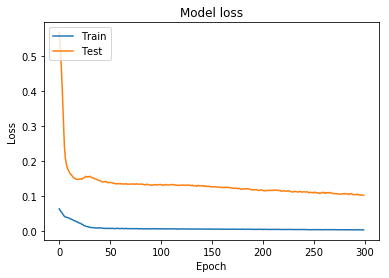

In [601]:
# plotLoss(history)  # IMP!

In [602]:
# x_test_t 

In [603]:
def calcError(model, x_test_t, y_test_t, y_pred_org, y_test_t_org):
    y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
    y_pred = y_pred.flatten()
    y_test_t = createDataset(y_test_t, batchSize)
    error = mean_squared_error(y_test_t, y_pred)
    return ("Error is", error, y_pred.shape, y_test_t.shape)

    print(y_pred[0:15])
    print(y_test_t[0:15])
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
    print(y_pred_org[0:15])
    print(y_test_t_org[0:15])

In [604]:
# calcError(model, x_test_t, y_test_t, y_pred_org, y_test_t_org)  # IMP!

('Error is', 0.010533800915214594, (20,), (20,))

In [605]:
# y_pred

In [606]:
from matplotlib import pyplot as plt

def plotPrediction(y_pred_org, y_test_t_org):
    stime = time.time()
    
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_test_t_org)
    plt.title('Prediction vs Real Stock Price')
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()
    print("program completed ", time.time() - stime)

In [642]:
# plotPrediction(y_pred_org, y_test_t_org) # IMP!

In [672]:
# make the indices numbers

closeData = data['Close']
timeData = list(range(len(data.index.values)))
newData = []
for i in range(len(closeData)):
    newData.append([timeData[i], closeData[i]])
# data.rename(index=range(len(timeData)))

data.index = pd.Series(timeData, name = 'Date')
# data

In [675]:
def predMainFunc1(data):

#     TIME_STEPS = 10 # [rram]
#     batchSize = 32 # [rram]


#     #####
#     params = {
#         "batch_size": 20,  # 20<16<10, 25 was a bust
#         "epochs": 300,
#         "lr": 0.00010000,
#         "time_steps": 60
#     }

#     iter_changes = "dropout_layers_0.4_0.4"

#     # INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
#     OUTPUT_PATH = '~/Desktop'
#     TIME_STEPS = params["time_steps"]
#     batchSize = params["batch_size"]
#     stime = time.time()
#     ###


    train_cols = ["Open","High","Low","Close", 'Volume']
    df_train, df_test = data, pd.Series(len(data) + 5) #let's assume 5 look-ahead days
#     print('df_test:', df_test)
#     print("Train and Test size", len(df_train), len(df_test))
    # scale the feature MinMax, build array
    x = df_train.loc[:,train_cols].values
    x_train = min_max_scaler.fit_transform(x)
    x_test = min_max_scaler.transform(df_test.loc[:,train_cols])


#     print('x_test before\n\n', df_test.loc[:,train_cols])
#     print((x_train.shape))
#     print((x_test.shape))



    
    return x_train, x_test


In [676]:
x_train, x_test = predMainFunc1(data)

IndexingError: Too many indexers

In [622]:

# X_test = np.asarray(range(6))

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# closing_price = model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)

IndexError: tuple index out of range

In [609]:
# # try with real testing data


# y_pred = lstm_model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

In [610]:
# is_update_model = True
# if model is None or is_update_model:
#     from keras import backend as K
#     print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
#     model = create_model()
    
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#                        patience=40, min_delta=0.0001)
    
#     mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#                           "best_model.h5"), monitor='val_loss', verbose=1,
#                           save_best_only=True, save_weights_only=False, mode='min', period=1)

#     # Not used here. But leaving it here as a reminder for future
#     r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
#                                   verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
#     csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
#     history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=batchSize,
#                         shuffle=False, validation_data=(createDataset(x_val, batchSize),
#                         createDataset(y_val, batchSize)), callbacks=[es, mcp, csv_logger])
    
#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

# # model.evaluate(x_test_t, y_test_t, batch_size=batchSize
# y_pred = model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])

# # convert the predicted value to range of real data
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the training data
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(batchSize)+"_"+time.ctime()+'.png'))

# # load the saved best model from above
# saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

# y_pred = saved_model.predict(createDataset(x_test_t, batchSize), batch_size=batchSize)
# y_pred = y_pred.flatten()
# y_test_t = createDataset(y_test_t, batchSize)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the prediction
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(y_pred_org)
# plt.plot(y_test_t_org)
# plt.title('Prediction vs Real Stock Price')
# plt.ylabel('Price')
# plt.xlabel('Days')
# plt.legend(['Prediction', 'Real'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(batchSize)+"_"+time.ctime()+'.png'))
# print_time("program completed ", stime)